In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from collections import Counter
import re
import zipfile
import warnings
warnings.filterwarnings("ignore")
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
import textblob, string
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from lightgbm import LGBMModel, LGBMClassifier

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
df = pd.read_csv('../../Data/category-data/all_cat.csv', encoding='latin', header=None)
df.columns = ['headline', 'category']

df.dropna(inplace=True)
print('df shape: ', df.shape)
labels = df.category.unique()
labels = list(labels)
labels

df shape:  (7241, 2)


['agriculture', 'culture', 'energy', 'labour', 'law', 'rights']

In [5]:
def clean_text(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    if len(text.split()) < 4:
        return np.nan
    return text

def make_table(filename, c1, x_axis, c2, y_axis='Accuracy'):
    filename = './docs/' + filename + '.csv'
    table = pd.DataFrame({
            x_axis: c1,
            y_axis: c2
            })
    table.to_csv(filename, index=False)

In [6]:
df['headline'] = df['headline'].apply(lambda text: clean_text(text))
df = df.dropna()

encoder = LabelEncoder()

X = df['headline']
y = encoder.fit_transform(df.category)
# y = pd.get_dummies(df['category'])

train_x, valid_x, train_y, valid_y = tts(X, y, test_size=0.2, random_state=0)
print('train_x shape:', train_x.shape)
print('valid_x shape:', valid_x.shape)
# encoder = LabelEncoder()
# train_y_onehot = train_y.copy().as_matrix()
# train_y = encoder.fit_transform(train_y.idxmax(axis=1))
# valid_y_onehot = valid_y.copy().as_matrix()
# valid_y = encoder.fit_transform(valid_y.idxmax(axis=1))

train_x shape: (5773,)
valid_x shape: (1444,)


In [7]:
df.category.value_counts()

culture        2179
energy         1244
labour         1223
rights          975
law             892
agriculture     704
Name: category, dtype: int64

In [8]:
sentences = df.headline.to_list()
sentences[2019]

'The What Founders On Cofounding Relationships Building Community And Radical Authenticity'

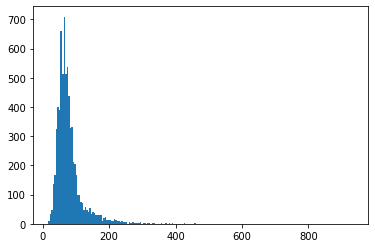

In [9]:
plt.hist([len(sen) for sen in sentences], bins=200)
plt.show()

### Analysis of words and n-grams for different categories

In [ ]:
def get_ngram_counts(df, X, y, ngrams=1):
    vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                                 stop_words=stop_words, ngram_range=(ngrams, ngrams))
    categories = list(y.columns)    
    for category in categories:
        filename = ('category/'+category+'_{}_grams').format(ngrams)
        print(category + '...')
        cat_df = df.where(df[category] == 1).dropna()
        cat_headline = vect.fit_transform(cat_df['headline'])
        sum_words = cat_headline.sum(axis=0)
        words_freq = [[word, sum_words[0, idx]] for word, idx in vect.vocabulary_.items()]
        words_freq = pd.DataFrame(sorted(words_freq, key = lambda x: x[1], reverse=True))
        make_table(filename, words_freq[0], ('{}_grams').format(ngrams),
                   words_freq[1], 'Frequency')

get_ngram_counts(df, X, y, ngrams=3)

max_sent_len = 0
for i in range(len(X)):
    max_sent_len = max(len(X.at[i].split()), max_sent_len)

print("Length of longest sentence: ", max_sent_len)

### Feature extraction for supervised models

In [11]:
"""
Count Vectorizer
"""
count_vect = CountVectorizer(analyzer='word', token_pattern='\w{1,}',
                             stop_words=stop_words, ngram_range=(1,2))
count_vect.fit(train_x)
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [12]:
"""
TF-IDF Vectorizer
"""

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                             ngram_range=(1,2))
tfidf_vect.fit(train_x)
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

`LDA topic modelling` is done to understand and identify the underlying topics prevalent in the sets of sentences belonging to a certain category.

In [ ]:
"""
LDA topic modelling
"""

lda_model = LatentDirichletAllocation(n_components=20, 
                                      learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [27]:
def train_model(classifier, train, label, valid, is_neural_net=False):
    start = time.time()
    
    if is_neural_net:
        classifier.fit(train, label, epochs=1, batch_size=256)
        predictions = classifier.predict(valid)
        print("Time taken: %.2f seconds" % (time.time()-start))
        return predictions, accuracy_score(predictions, valid_y_onehot)
    else:
        classifier.fit(train, label)
        predictions = classifier.predict(valid)
        train_predictions = classifier.predict(train)
        print("Time taken: %.2f seconds" % (time.time()-start))
        return predictions, [accuracy_score(predictions, valid_y), accuracy_score(train_predictions, label)]

### Evaluating the Count and TF-IDF features using supervised models


Models used are:

    1. Logistic Regression
    2. Naive Bayes
    3. Random Forest
    4. Gradient Boosting
    5. XGBoost
    6. LGBoost
       

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [42]:
LR = LogisticRegression()
LR.fit(xtrain_count, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
lr_count_pred = LR.predict(xvalid_count)
print("LR, WordLevel Count accuracy (test, train): [{.3f}, {.3f}]",
      accuracy_score(lr_count_pred, valid_y),
      accuracy_score(LR.predict(xtrain_count), train_y))
print(classification_report(valid_y, lr_count_pred, target_names=labels))

LR, WordLevel Count accuracy (test, train): [{.3f}, {.3f}] 0.8074792243767313 0.9892603499047289
              precision    recall  f1-score   support

 agriculture       0.93      0.75      0.83       145
     culture       0.69      0.92      0.79       425
      energy       0.91      0.77      0.83       252
      labour       0.92      0.71      0.80       254
         law       0.74      0.66      0.70       172
      rights       0.91      0.92      0.92       196

    accuracy                           0.81      1444
   macro avg       0.85      0.79      0.81      1444
weighted avg       0.83      0.81      0.81      1444



In [44]:
lr_tfidf_pred, accuracy = train_model(LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF accuracy (test, train): [{.3f}, {.3f}]", accuracy)      
print(classification_report(valid_y, lr_tfidf_pred, target_names=labels))

Time taken: 0.96 seconds
LR, WordLevel TF-IDF accuracy (test, train): [{.3f}, {.3f}] [0.7693905817174516, 0.8796119868352676]
              precision    recall  f1-score   support

 agriculture       0.99      0.58      0.73       145
     culture       0.61      0.97      0.75       425
      energy       0.92      0.66      0.77       252
      labour       0.91      0.68      0.78       254
         law       0.84      0.51      0.64       172
      rights       0.90      0.96      0.93       196

    accuracy                           0.77      1444
   macro avg       0.86      0.73      0.77      1444
weighted avg       0.82      0.77      0.77      1444



In [45]:
nb_count_pred, accuracy = train_model(MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("Naive Bayes, Count Vectors accuracy (test, train): ", accuracy)
print(classification_report(valid_y, nb_count_pred, target_names=labels))

Time taken: 0.04 seconds
Naive Bayes, Count Vectors accuracy (test, train):  [0.7991689750692521, 0.9819851030659968]
              precision    recall  f1-score   support

 agriculture       0.93      0.76      0.84       145
     culture       0.76      0.84      0.80       425
      energy       0.83      0.81      0.82       252
      labour       0.82      0.75      0.78       254
         law       0.73      0.65      0.69       172
      rights       0.81      0.94      0.87       196

    accuracy                           0.80      1444
   macro avg       0.81      0.79      0.80      1444
weighted avg       0.80      0.80      0.80      1444



In [46]:
nb_tfidf_pred, accuracy = train_model(MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("Naive Bayes, WordLevel TF-IDF accuracy (test, train): ", accuracy)
print(classification_report(valid_y, nb_tfidf_pred, target_names=labels))

Time taken: 0.05 seconds
Naive Bayes, WordLevel TF-IDF accuracy (test, train):  [0.6655124653739612, 0.8796119868352676]
              precision    recall  f1-score   support

 agriculture       1.00      0.28      0.43       145
     culture       0.50      0.99      0.66       425
      energy       0.93      0.64      0.76       252
      labour       0.88      0.56      0.68       254
         law       0.82      0.18      0.30       172
      rights       0.89      0.85      0.87       196

    accuracy                           0.67      1444
   macro avg       0.83      0.58      0.62      1444
weighted avg       0.78      0.67      0.64      1444



In [47]:
SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

start = time.time()
SGD.fit(xtrain_count, train_y)
print('Time taken %.3f' % (time.time()-start))
sgd_count_pred = SGD.predict(xvalid_count)
print("SGD, Count Vectors accuracy (test, train): ", accuracy_score(sgd_count_pred, valid_y))
print(classification_report(valid_y, sgd_count_pred, target_names=labels))

Time taken 0.129
SGD, Count Vectors accuracy (test, train):  0.8116343490304709
              precision    recall  f1-score   support

 agriculture       0.90      0.77      0.83       145
     culture       0.71      0.89      0.79       425
      energy       0.89      0.79      0.83       252
      labour       0.92      0.72      0.81       254
         law       0.73      0.67      0.70       172
      rights       0.90      0.94      0.92       196

    accuracy                           0.81      1444
   macro avg       0.84      0.80      0.81      1444
weighted avg       0.83      0.81      0.81      1444



In [52]:
Forest = RandomForestClassifier(n_estimators=100)

start = time.time()
Forest.fit(xtrain_count, train_y)
forest_count_pred = Forest.predict(xvalid_count)
print('Time taken %.3f' % (time.time()-start))
print("RandomForest, Count Vectors accuracy (test, train): ", accuracy_score(forest_count_pred, valid_y))
print(classification_report(valid_y, forest_count_pred, target_names=labels))

# forest_tfidf_pred, accuracy = train_model(Forest, xtrain_tfidf, train_y, xvalid_tfidf)
# print("RandomForest, TF-IDF accuracy (test, train): ", accuracy)

Time taken 25.824
RandomForest, Count Vectors accuracy (test, train):  0.7915512465373962
              precision    recall  f1-score   support

 agriculture       0.96      0.76      0.85       145
     culture       0.67      0.89      0.76       425
      energy       0.92      0.76      0.83       252
      labour       0.92      0.69      0.79       254
         law       0.68      0.65      0.67       172
      rights       0.88      0.90      0.89       196

    accuracy                           0.79      1444
   macro avg       0.84      0.77      0.80      1444
weighted avg       0.82      0.79      0.79      1444



In [53]:
# GBoost = GradientBoostingClassifier(n_estimators=30, learning_rate=0.05, 
#                                     max_depth=4, max_features='sqrt', 
#                                     min_samples_leaf=10, min_samples_split=10, 
#                                     random_state=5, verbose=1)
GBoost = GradientBoostingClassifier(random_state=0, verbose=1)
GBoost.fit(xtrain_count.tocsc(), train_y)
gb_count_pred = GBoost.predict(xvalid_count.tocsc())
print("GBoost, Count Vectors accuracy (test, train): ", accuracy_score(gb_count_pred, valid_y))
print(classification_report(valid_y, gb_count_pred, target_names=labels))

# gb_count_pred, accuracy = train_model(GBoost, xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
# print("GBoost, Count Vectors accuracy (test, train): ", accuracy)

# gb_tfidf_pred, accuracy = train_model(GBoost, xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
# print("GBoost, WordLevel TF-IDF accuracy (test, train): ", accuracy)

      Iter       Train Loss   Remaining Time 
         1        9005.8492            1.21m
         2        8459.9861            1.21m
         3        8056.5137            1.18m
         4        7750.9876            1.18m
         5        7491.0045            1.15m
         6        7271.5394            1.14m
         7        7088.1523            1.08m
         8        6927.1777           58.93s
         9        6784.2388           54.47s
        10        6663.7182           50.85s
        20        5873.3789           33.07s
        30        5433.5912           32.70s
        40        5101.6246           26.31s
        50        4840.1554           20.58s
        60        4631.0654           17.66s
        70        4438.8051           12.42s
        80        4276.2110            8.29s
        90        4144.3979            4.21s
       100        4007.2345            0.00s
GBoost, Count Vectors accuracy (test, train):  0.7541551246537396
              precision    recall

In [55]:
start = time.time()

XGBoost = XGBClassifier(colsample_bytree=0.8, gamma=0.0468,
                             learning_rate=0.1, max_depth=5,
                             min_child_weight=1, n_estimators=10,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.8, silent=1, verbose_eval=True,
                             random_state=2019, n_thread=-1, verbose=1)

XGBoost.fit(xtrain_count.tocsc(), train_y)
xgb_count_pred = XGBoost.predict(xvalid_count.tocsc())
print('Time taken %.3f' % (time.time()-start))
print("XGB, Count Vectors accuracy (test, train): ", accuracy_score(xgb_count_pred, valid_y))
print(classification_report(valid_y, xgb_count_pred, target_names=labels))

# xgb_count_pred, accuracy = train_model(XGBoost, xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
# print("XGB, Count Vectors accuracy (test, train): ", accuracy)

# xgb_tfidf_pred, accuracy = train_model(XGBoost, xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
# print("XGB, WordLevel TF-IDF accuracy (test, train): ", accuracy)

XGB, Count Vectors accuracy (test, train):  0.6876731301939059
              precision    recall  f1-score   support

 agriculture       0.93      0.56      0.70       145
     culture       0.51      0.92      0.66       425
      energy       0.96      0.54      0.69       252
      labour       0.97      0.59      0.74       254
         law       0.67      0.48      0.56       172
      rights       0.89      0.77      0.82       196

    accuracy                           0.69      1444
   macro avg       0.82      0.64      0.69      1444
weighted avg       0.78      0.69      0.69      1444

